 # Google Trace Project

In [2]:
!which python

/mnt/netapp2/Store_uni/home/ulc/cursos/curso363/mypython/bin/python


# 1. Initialisation et Chargement des Donn√©es

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, BooleanType, StringType
import matplotlib.pyplot as plt

## Task Usage

In [4]:
# Cr√©ation de la session Spark
spark = SparkSession.builder \
    .appName("Analyse Google Cluster Trace") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/05 12:28:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#############################################
# Chargement des donn√©es task_usage
#############################################

# D√©finition du sch√©ma pour task_usage (renommage des colonnes pour faciliter la manipulation)
schema_task_usage = StructType([
    StructField("start_time", IntegerType(), True),
    StructField("end_time", IntegerType(), True),
    StructField("job_id", IntegerType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", IntegerType(), True),
    StructField("cpu_rate", FloatType(), True),
    StructField("canonical_memory_usage", FloatType(), True),
    StructField("assigned_memory_usage", FloatType(), True),
    StructField("unmapped_page_cache", FloatType(), True),
    StructField("total_page_cache", FloatType(), True),
    StructField("max_memory_usage", FloatType(), True),
    StructField("disk_io_time", FloatType(), True),
    StructField("local_disk_space_usage", FloatType(), True),
    StructField("max_cpu_rate", FloatType(), True),
    StructField("max_disk_io_time", FloatType(), True),
    StructField("cycles_per_instruction", FloatType(), True),
    StructField("memory_accesses_per_instruction", FloatType(), True),
    StructField("sample_portion", FloatType(), True),
    StructField("aggregation_type", BooleanType(), True),
    StructField("sampled_cpu_usage", FloatType(), True)
])

# Chemin d'acc√®s aux fichiers CSV (ajustez le chemin selon votre environnement)
task_usage_path = "data/task_usage/*.csv"
# task_usage_path = "data/task_usage/part-00003-of-00500.csv"

# Lecture des donn√©es task_usage
df_task_usage = spark.read.csv(task_usage_path, header=False, schema=schema_task_usage)
print("Nombre de lignes brutes dans task_usage :", df_task_usage.count())
df_task_usage.show(5)

Nombre de lignes brutes dans task_usage : 1232799308
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+
|start_time| end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--

# 2. Nettoyage et Pr√©paration des Donn√©es task_usage

In [6]:
# Nettoyage des donn√©es : suppression des lignes o√π job_id est null ou les consommations sont √† 0
df_task_usage_clean = df_task_usage.filter(
    (F.col("job_id").isNotNull()) & 
    (F.col("canonical_memory_usage") > 0) & 
    (F.col("sampled_cpu_usage") > 0)
)
print("Nombre de lignes apr√®s nettoyage task_usage :", df_task_usage_clean.count())
df_task_usage_clean.show(5)

# Ajout d'une colonne "duration" pour conna√Ætre la dur√©e d'ex√©cution (end_time - start_time)
df_task_usage_clean = df_task_usage_clean.withColumn("duration", F.col("end_time") - F.col("start_time"))
df_task_usage_clean.select("start_time", "end_time", "duration").show(5)

Nombre de lignes apr√®s nettoyage task_usage : 7901086
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+
|start_time| end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|
+----------+---------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+

Nous filtrons les enregistrements en supprimant ceux dont le job_id est nul ou dont la consommation m√©moire ou CPU est nulle. Puis, nous calculons la dur√©e d‚Äôex√©cution de chaque enregistrement.

Choix effectu√©s :

Le filtrage sur les valeurs strictement sup√©rieures √† 0 permet d‚Äô√©liminer les enregistrements non significatifs pour l‚Äôanalyse des ressources.

La dur√©e est utilis√©e pour pond√©rer le calcul de la consommation moyenne, ce qui refl√®te mieux l‚Äôimpact global de la t√¢che.

## (Stockage des donn√©es filtr√©es)

Etant donn√© que les √©tapes pr√©c√©dentes sont tr√®s longue √† tourner, nous avons d√©cider de stocker notre dataframe filtr√© dans un dossier parquet qui sera tr√®s simple de lire s'il on veut retravailler sur le projet sans run toutes les cellules pr√©c√©dentes.

In [7]:
# √âcriture du DataFrame nettoy√© en format Parquet
df_task_usage_clean.write.mode("overwrite").parquet("task_usage_clean.parquet")

25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 90.31% for 8 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 80.28% for 9 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 72.25% for 10 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 65.68% for 11 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 60.21% for 12 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749,287 bytes) of heap memory
Scaling row group sizes to 55.58% for 13 writers
25/02/05 12:59:40 WARN MemoryManager: Total allocation exceeds 95.00% (969,749

Il nous suffit de lire le parquet pour sauter toutes les √©tapes pr√©c√©dentes.

In [8]:
df_task_usage_clean = spark.read.parquet("task_usage_clean.parquet")
df_task_usage_clean.show(5)

+----------+--------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+-----------------+--------+
|start_time|end_time| job_id|task_index|machine_id|cpu_rate|canonical_memory_usage|assigned_memory_usage|unmapped_page_cache|total_page_cache|max_memory_usage|disk_io_time|local_disk_space_usage|max_cpu_rate|max_disk_io_time|cycles_per_instruction|memory_accesses_per_instruction|sample_portion|aggregation_type|sampled_cpu_usage|duration|
+----------+--------+-------+----------+----------+--------+----------------------+---------------------+-------------------+----------------+----------------+------------+----------------------+------------+----------------+----------------------+-------------------------------+--------------+----------------+--------

# 3. Agr√©gation pour Extraire les Indicateurs par T√¢che

Pour chaque couple (job_id, task_index), nous calculons :

Le pic de consommation (valeur maximale).

La consommation moyenne pond√©r√©e par la dur√©e (pour tenir compte de l‚Äôintensit√© sur la dur√©e).

Nous d√©finissons ensuite une m√©trique combin√©e en faisant la moyenne de ces deux valeurs.

In [9]:
# Agr√©gation par t√¢che pour obtenir les indicateurs de consommation
df_task_stats = df_task_usage_clean.groupBy("job_id", "task_index").agg(
    F.max("max_memory_usage").alias("max_memory_usage"),
    (F.sum(F.col("canonical_memory_usage") * F.col("duration")) / F.sum("duration")).alias("avg_memory_usage"),
    F.max("sampled_cpu_usage").alias("max_cpu_usage"),
    (F.sum(F.col("sampled_cpu_usage") * F.col("duration")) / F.sum("duration")).alias("avg_cpu_usage")
)
df_task_stats.show(5)

# Calcul des valeurs combin√©es (moyenne de la valeur max et de la moyenne)
df_task_stats = df_task_stats.withColumn("combined_memory_usage", 
                                           (F.col("max_memory_usage") + F.col("avg_memory_usage")) / 2) \
                             .withColumn("combined_cpu_usage", 
                                           (F.col("max_cpu_usage") + F.col("avg_cpu_usage")) / 2)
df_task_stats.show(20)

+----------+----------+----------------+----------------+-------------+--------------------+
|    job_id|task_index|max_memory_usage|avg_memory_usage|max_cpu_usage|       avg_cpu_usage|
+----------+----------+----------------+----------------+-------------+--------------------+
| 192299653|        23|         0.02594|        0.022238|       0.1592|           0.0380862|
| 192299653|       171|         0.02328|        0.021712|       0.3315|           0.0103264|
| 192299653|       290|         0.02356|        0.021862|       0.1045|           0.0106502|
| 840454103|        19|        0.002708|        0.001608|       0.1716|0.018860572001302083|
|1005831090|        24|        5.293E-4|       3.5648E-4|     0.001385|1.338925999348958...|
+----------+----------+----------------+----------------+-------------+--------------------+
only showing top 5 rows



+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+
|    job_id|task_index|max_memory_usage|    avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|
+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+
| 192299653|        23|         0.02594|            0.022238|       0.1592|           0.0380862| 0.024088999574124813| 0.09864309889135361|
| 192299653|       171|         0.02328|            0.021712|       0.3315|           0.0103264| 0.022496000157058237| 0.17091319690055848|
| 192299653|       290|         0.02356|            0.021862|       0.1045|           0.0106502| 0.022711000291764736|0.057575101579523086|
| 840454103|        19|        0.002708|            0.001608|       0.1716|0.018860572001302083| 0.002157999949060...| 0.09523028553573482|
|1005831090|        

# 4. Int√©gration des Informations de task_events

In [10]:
#############################################
# Chargement des donn√©es task_events
#############################################

# D√©finition du sch√©ma pour task_events (renommage des colonnes)
schema_task_events = StructType([
    StructField("time", IntegerType(), True),
    StructField("missing_info", IntegerType(), True),
    StructField("job_id", IntegerType(), True),
    StructField("task_index", IntegerType(), True),
    StructField("machine_id", IntegerType(), True),
    StructField("event_type", IntegerType(), True),
    StructField("user", StringType(), True),
    StructField("scheduling_class", IntegerType(), True),
    StructField("priority", IntegerType(), True),
    StructField("cpu_request", FloatType(), True),
    StructField("memory_request", FloatType(), True),
    StructField("disk_space_request", FloatType(), True),
    StructField("different_machines_restriction", BooleanType(), True)
])

# Chemin d'acc√®s aux fichiers task_events
task_events_path = "data/task_events/*.csv"

# Lecture des donn√©es task_events
df_task_events = spark.read.csv(task_events_path, header=False, schema=schema_task_events)
print("Nombre de lignes brutes dans task_events :", df_task_events.count())
df_task_events.show(5)

# Nettoyage : suppression des enregistrements sans job_id et s√©lection des colonnes utiles
df_task_events_clean = df_task_events.filter(F.col("job_id").isNotNull())
df_task_events_clean = df_task_events_clean.select("job_id", "task_index", "priority").dropDuplicates()
df_task_events_clean.show(5)

# Jointure entre les statistiques calcul√©es et les informations de priorit√©
df_task_stats_joined = df_task_stats.join(df_task_events_clean, on=["job_id", "task_index"], how="inner")
print("Nombre de lignes apr√®s jointure :", df_task_stats_joined.count())
df_task_stats_joined.show(5)

df_task_stats_joined = df_task_stats_joined.cache()

Nombre de lignes brutes dans task_events : 144648288
+----+------------+------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|time|missing_info|job_id|task_index|machine_id|event_type|                user|scheduling_class|priority|cpu_request|memory_request|disk_space_request|different_machines_restriction|
+----+------------+------+----------+----------+----------+--------------------+----------------+--------+-----------+--------------+------------------+------------------------------+
|NULL|        NULL|  NULL|      2025| 317469463|         2|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          NULL|
|NULL|        NULL|  NULL|      2025|      NULL|         0|1wRYrkVgrhQf/fNZQ...|               1|       0|     0.0625|       0.03961|          3.815E-5|                          NULL|
|NULL|        NULL|  NULL| 

+----------+----------+--------+
|    job_id|task_index|priority|
+----------+----------+--------+
| 501114088|         3|       0|
|1412625411|        91|       0|
|1412625411|         3|       0|
| 515042969|        24|       0|
|1412625411|        70|       0|
+----------+----------+--------+
only showing top 5 rows



Nombre de lignes apr√®s jointure : 953


+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
|    job_id|task_index|max_memory_usage|    avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage|  combined_cpu_usage|priority|
+----------+----------+----------------+--------------------+-------------+--------------------+---------------------+--------------------+--------+
| 501114088|         3|        0.001007|           4.4554E-4|      0.05884|          1.19768E-4| 7.262699921917915E-4|0.029479883569654464|       0|
|1170482497|         0|         0.09485| 0.08664599866666667|       0.2593|4.321999895833333...|  0.09074800119299825|   0.129866096752299|       1|
|1303031391|        18|        5.684E-4|           1.7454E-4|     0.004501|           4.4624E-5| 3.714700103555619...|0.002272812023365...|       1|
|1303031391|        24|        0.003048|            0.002499|     0.002815|           2.2701E-5| 0.0027734

La priorit√© peut √™tre utilis√©e pour classifier les t√¢ches dominantes par niveau de criticit√©.

La jointure permet d‚Äôenrichir nos statistiques avec une dimension suppl√©mentaire d‚Äôanalyse.

# 5. Identification des T√¢ches Dominantes
√Ä partir du DataFrame enrichi, nous classons les t√¢ches selon leurs m√©triques combin√©es pour la m√©moire et pour le CPU.

In [11]:
# Extraction des t√¢ches dominantes par consommation m√©moire et CPU
dominant_tasks_memory = df_task_stats_joined.orderBy(F.desc("combined_memory_usage"))
dominant_tasks_cpu = df_task_stats_joined.orderBy(F.desc("combined_cpu_usage"))

print("Top 5 t√¢ches par consommation m√©moire combin√©e:")
dominant_tasks_memory.show(5)

print("Top 5 t√¢ches par consommation CPU combin√©e:")
dominant_tasks_cpu.show(5)

Top 5 t√¢ches par consommation m√©moire combin√©e:


+----------+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
|    job_id|task_index|max_memory_usage|   avg_memory_usage|max_cpu_usage|       avg_cpu_usage|combined_memory_usage| combined_cpu_usage|priority|
+----------+----------+----------------+-------------------+-------------+--------------------+---------------------+-------------------+--------+
| 259235987|         0|           0.334|            0.29306|       0.6445|            0.148762|  0.31352999570846557| 0.3966310085830689|      10|
| 643856032|         0|          0.1122|0.09472800266666667|       0.1594|           0.0021093|  0.10346400102934965|0.08075465058412552|      10|
|1297383150|         0|          0.1161|           0.088428|       0.7812|0.036194399833333335|   0.1022639991774559| 0.4086971957681834|      10|
| 411248937|         0|          0.1128|           0.088624|       0.3008|           0.1231954|  0.10071200104904174|0

# 6. Analyse de la R√©partition par Priorit√© et Corr√©lation CPU/M√©moire

## Classification par priorit√©

In [12]:
# Comptage des t√¢ches par priorit√©
df_by_priority = df_task_stats_joined.groupBy("priority").count().orderBy("priority")
print("R√©partition des t√¢ches par priorit√©:")
df_by_priority.show()

R√©partition des t√¢ches par priorit√©:
+--------+-----+
|priority|count|
+--------+-----+
|       0|   15|
|       1|   83|
|       8|    3|
|       9|  718|
|      10|  134|
+--------+-----+



La r√©partition des t√¢ches par priorit√© montre une concentration majeure sur les priorit√©s 9 (718 t√¢ches) et 10 (134 t√¢ches), tandis que les priorit√©s 0, 1 et 8 sont tr√®s peu repr√©sent√©es. Cela sugg√®re que la majorit√© des ressources du cluster sont allou√©es aux t√¢ches de haute priorit√©, ce qui pourrait impacter l‚Äô√©quilibrage de charge et la gestion des ressources.

## Analyse de corr√©lation

Nous √©tudions la corr√©lation entre la consommation combin√©e de CPU et de m√©moire. Pour mieux comprendre l‚Äôeffet d‚Äôun seuil sur la consommation CPU, nous filtrons progressivement le DataFrame selon diff√©rents seuils sur combined_cpu_usage et calculons la corr√©lation correspondante.

Threshold: 0.0, Count: 953, Correlation: 0.4961321516958208
Threshold: 0.01, Count: 701, Correlation: 0.39564634866824083
Threshold: 0.02, Count: 657, Correlation: 0.3829756943078207
Threshold: 0.03, Count: 603, Correlation: 0.34270793827524304
Threshold: 0.04, Count: 538, Correlation: 0.33493158286377184
Threshold: 0.05, Count: 521, Correlation: 0.3421819767627592
Threshold: 0.06, Count: 474, Correlation: 0.3501656884583014
Threshold: 0.07, Count: 332, Correlation: 0.4115122931708143
Threshold: 0.08, Count: 236, Correlation: 0.48396116985968735
Threshold: 0.09, Count: 195, Correlation: 0.5495403639134677
Threshold: 0.1, Count: 158, Correlation: 0.5683794373011625
Threshold: 0.11, Count: 117, Correlation: 0.5616699648800205
Threshold: 0.12, Count: 100, Correlation: 0.5400956201197704
Threshold: 0.13, Count: 87, Correlation: 0.6209369898346407
Threshold: 0.14, Count: 75, Correlation: 0.633325077595925
Threshold: 0.15, Count: 64, Correlation: 0.6545140627525032
Threshold: 0.16, Count: 46

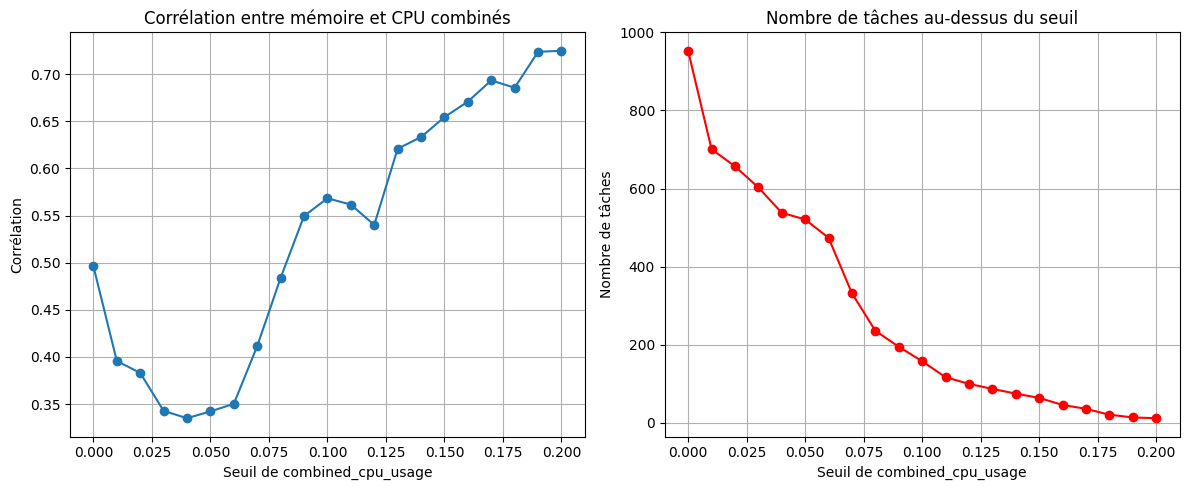

In [13]:
# D√©finition d'une liste de seuils pour combined_cpu_usage
thresholds = [k/100 for k in range(0, 21)]  # de 0.00 √† 0.20
correlation_results = []

for thresh in thresholds:
    filtered = df_task_stats_joined.filter(F.col("combined_cpu_usage") >= thresh)
    count = filtered.count()
    # Calcul de la corr√©lation si le nombre de lignes est suffisant
    corr_val = filtered.stat.corr("combined_memory_usage", "combined_cpu_usage") if count > 1 else None
    correlation_results.append((thresh, count, corr_val))
    print(f"Threshold: {thresh}, Count: {count}, Correlation: {corr_val}")

# Extraction des r√©sultats pour la visualisation
thresh_list = [x[0] for x in correlation_results]
counts_list = [x[1] for x in correlation_results]
corr_list = [x[2] for x in correlation_results]

# Visualisation des r√©sultats
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(thresh_list, corr_list, marker='o')
plt.title("Corr√©lation entre m√©moire et CPU combin√©s")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Corr√©lation")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(thresh_list, counts_list, marker='o', color='red')
plt.title("Nombre de t√¢ches au-dessus du seuil")
plt.xlabel("Seuil de combined_cpu_usage")
plt.ylabel("Nombre de t√¢ches")
plt.grid(True)

plt.tight_layout()
plt.show()

### üìä Analyse des r√©sultats

- La **corr√©lation entre m√©moire et CPU** est relativement faible pour les t√¢ches √† faible consommation de CPU, mais elle augmente significativement √† partir d‚Äôun seuil de 0.08, atteignant **0.72** pour les t√¢ches les plus gourmandes en CPU.
- Cette tendance sugg√®re que **les t√¢ches fortement consommatrices de CPU n√©cessitent √©galement plus de m√©moire**, expliquant ainsi une meilleure corr√©lation √† ces seuils √©lev√©s.
- Le **nombre de t√¢ches d√©cro√Æt exponentiellement** avec l‚Äôaugmentation du seuil combined_cpu_usage, indiquant que **la majorit√© des t√¢ches ont une faible utilisation CPU**.
- √Ä **0.1**, il ne reste qu‚Äôenviron **150 t√¢ches**, et √† **0.2**, seulement **12**, montrant que **les jobs intensifs en CPU sont rares** mais fortement corr√©l√©s avec une forte consommation m√©moire.
- Cette distribution explique pourquoi la corr√©lation devient plus marqu√©e aux seuils √©lev√©s : seules **les t√¢ches les plus exigeantes en ressources subsistent**.

**Conclusion** : L‚Äôanalyse met en √©vidence que les **jobs les plus dominants en CPU sont aussi ceux qui consomment le plus de m√©moire**, ce qui pourrait √™tre explor√© davantage en analysant leur **priorit√©, type et impact global sur le cluster**. 

## Scatter Plot

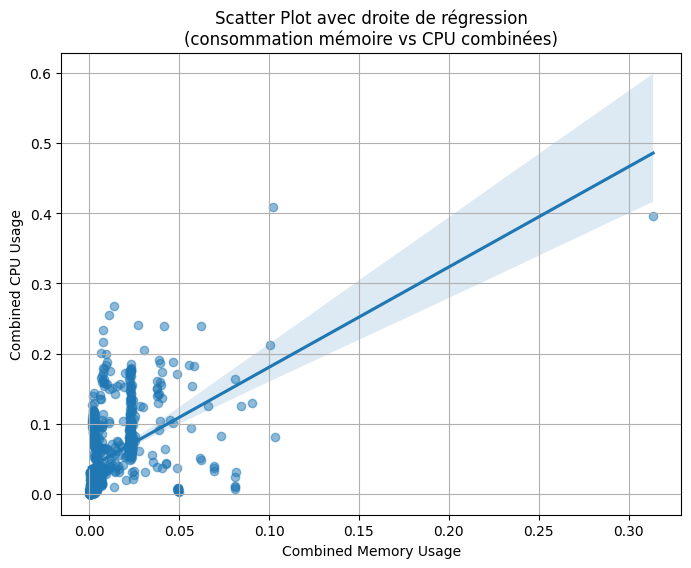

In [14]:
import seaborn as sns

# Convertir le DataFrame Spark en Pandas (attention : cette op√©ration doit √™tre faite sur un √©chantillon ou un DataFrame de taille raisonnable)
df_pd = df_task_stats_joined.select("combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(8,6))
sns.regplot(x="combined_memory_usage", y="combined_cpu_usage", data=df_pd, scatter_kws={'alpha':0.5})
plt.title("Scatter Plot avec droite de r√©gression\n(consommation m√©moire vs CPU combin√©es)")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Combined CPU Usage")
plt.grid(True)
plt.show()

### üìä Analyse du Scatter Plot (M√©moire vs CPU combin√©s)

- Ce **scatter plot** repr√©sente la relation entre la **consommation m√©moire combin√©e** (combined_memory_usage) et la **consommation CPU combin√©e** (combined_cpu_usage).
- La **droite de r√©gression** montre une tendance **croissante**, indiquant une **corr√©lation positive** entre ces deux variables.
- Cependant, on observe une **grande dispersion** des points, particuli√®rement pour les faibles valeurs de m√©moire et de CPU, ce qui sugg√®re que la relation n'est pas strictement lin√©aire.
- La majorit√© des t√¢ches ont une **faible consommation m√©moire (< 0.05)** et CPU, mais certaines **exceptions avec une forte consommation m√©moire** sont visibles au-del√† de 0.10.
- L‚Äô**intervalle de confiance** (bande bleue autour de la droite) s‚Äô√©largit pour les valeurs √©lev√©es, indiquant **plus d'incertitude** sur la relation dans cette zone.

Il existe donc une **corr√©lation positive** entre l'utilisation de la m√©moire et du CPU, mais elle est **plus marqu√©e pour les t√¢ches fortement consommatrices**. Une analyse plus approfondie des t√¢ches extr√™mes permettrait de mieux comprendre ces tendances. 


## Histogrammes 

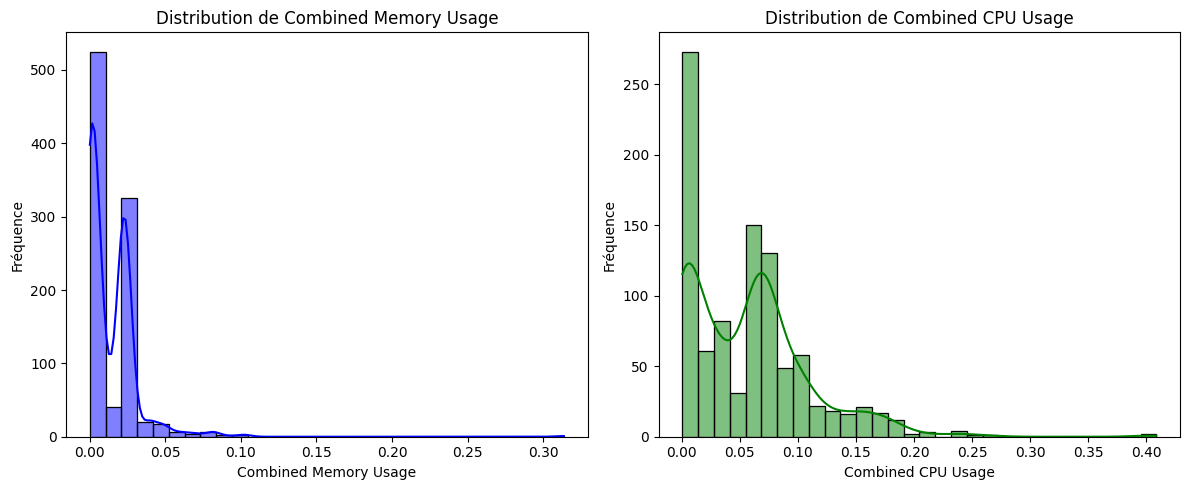

In [15]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df_pd["combined_memory_usage"], bins=30, kde=True, color='blue')
plt.title("Distribution de Combined Memory Usage")
plt.xlabel("Combined Memory Usage")
plt.ylabel("Fr√©quence")

plt.subplot(1,2,2)
sns.histplot(df_pd["combined_cpu_usage"], bins=30, kde=True, color='green')
plt.title("Distribution de Combined CPU Usage")
plt.xlabel("Combined CPU Usage")
plt.ylabel("Fr√©quence")

plt.tight_layout()
plt.show()

### üìä Analyse des distributions de consommation m√©moire et CPU

- Les histogrammes illustrent la distribution des valeurs de **combined_memory_usage** et **combined_cpu_usage**, accompagn√©s d‚Äôune **courbe de densit√© (KDE)** pour mieux visualiser leur r√©partition.
- La distribution de la **consommation m√©moire** est fortement **asym√©trique √† droite**, avec une grande majorit√© des t√¢ches ayant une consommation **tr√®s faible (< 0.05)** et quelques outliers consommant davantage.
- La **consommation CPU** suit une distribution similaire mais l√©g√®rement plus √©tal√©e, indiquant qu‚Äôun plus grand nombre de t√¢ches utilisent des valeurs interm√©diaires de CPU, avec une **concentration autour de 0.02 - 0.05**.
- Les deux distributions montrent que la majorit√© des t√¢ches ont une **faible consommation de ressources**, mais qu'il existe une queue longue, sugg√©rant l'existence de **jobs dominants en m√©moire et CPU**.

Ainsi, la plupart des t√¢ches utilisent tr√®s peu de m√©moire et de CPU, mais une **minorit√© de t√¢ches fortement consommatrices pourrait impacter les performances du cluster**.

## Boxplots par classe de priorit√©


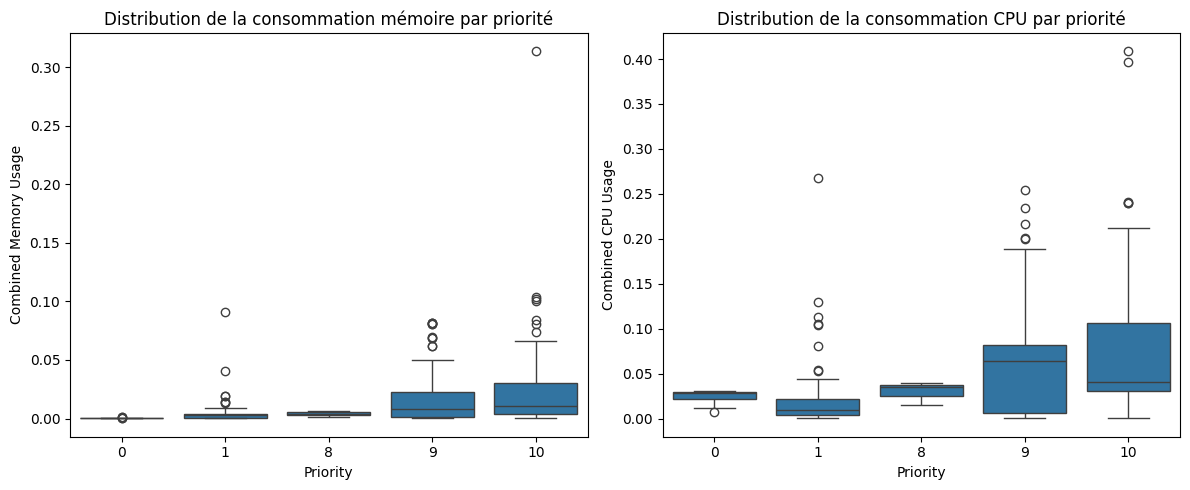

In [16]:
df_pd_priority = df_task_stats_joined.select("priority", "combined_memory_usage", "combined_cpu_usage").toPandas()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x="priority", y="combined_memory_usage", data=df_pd_priority)
plt.title("Distribution de la consommation m√©moire par priorit√©")
plt.xlabel("Priority")
plt.ylabel("Combined Memory Usage")

plt.subplot(1,2,2)
sns.boxplot(x="priority", y="combined_cpu_usage", data=df_pd_priority)
plt.title("Distribution de la consommation CPU par priorit√©")
plt.xlabel("Priority")
plt.ylabel("Combined CPU Usage")

plt.tight_layout()
plt.show()

### üìä Analyse des boxplots par classe de priorit√©

- Ces **boxplots** permettent de visualiser la r√©partition de la **consommation m√©moire et CPU** en fonction de la **priorit√© des t√¢ches**.
- On observe que les t√¢ches avec une **priorit√© plus √©lev√©e (9 et 10)** ont tendance √† consommer **plus de m√©moire et de CPU**, bien que la majorit√© des valeurs restent relativement faibles.
- Les **m√©dianes** restent similaires pour les priorit√©s faibles (0, 1, 8), mais il y a une **plus grande variabilit√©** et davantage d'**outliers** pour les t√¢ches de **priorit√© 9 et 10**, sugg√©rant que certains jobs critiques sont plus gourmands en ressources.
- Le **nombre d'outliers** augmente significativement pour les priorit√©s √©lev√©es, indiquant qu'un petit nombre de t√¢ches consomment **beaucoup plus de ressources que la majorit√©**.

Les t√¢ches √† **priorit√© √©lev√©e** semblent avoir **une plus grande consommation de m√©moire et CPU**, mais avec une forte variabilit√©.

## Heatmap de la matrice de corr√©lation

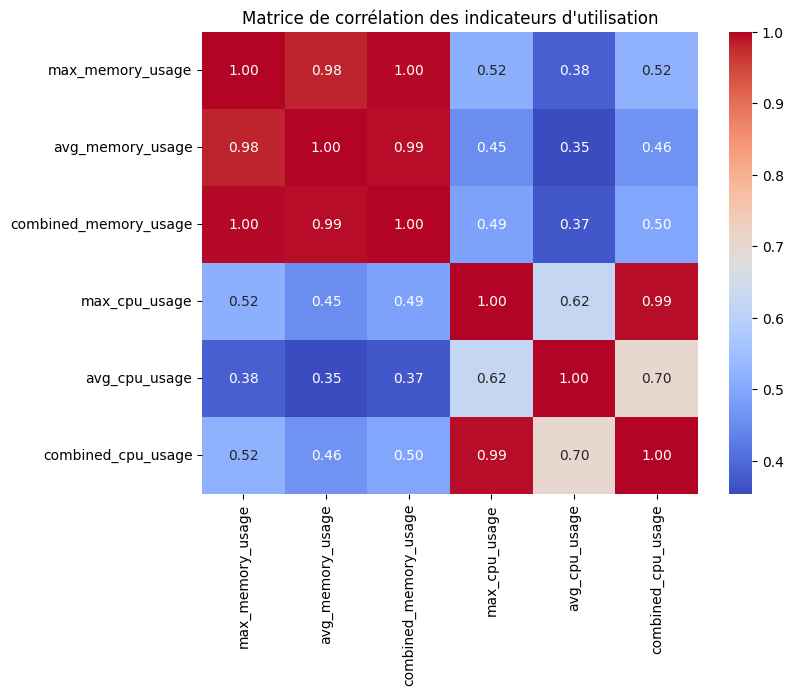

In [17]:
# S√©lectionner plusieurs colonnes d'int√©r√™t
df_pd_corr = df_task_stats_joined.select(
    "max_memory_usage", "avg_memory_usage", "combined_memory_usage",
    "max_cpu_usage", "avg_cpu_usage", "combined_cpu_usage"
).toPandas()

corr_matrix = df_pd_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corr√©lation des indicateurs d'utilisation")
plt.show()


### üìä Analyse de la matrice de corr√©lation des indicateurs d'utilisation

- Cette matrice montre la **corr√©lation** entre diff√©rents indicateurs d'utilisation de la m√©moire et du CPU.
- Les m√©triques de **m√©moire (max, avg, combined)** sont **tr√®s fortement corr√©l√©es entre elles** (‚â• 0.98), indiquant que la consommation maximale et moyenne de m√©moire √©voluent de mani√®re similaire.
- Les **indicateurs CPU** (max, avg, combined) pr√©sentent aussi des **corr√©lations √©lev√©es**, en particulier entre max_cpu_usage et combined_cpu_usage (0.99).
- La corr√©lation entre **m√©moire et CPU** est **mod√©r√©e** (~0.45 √† 0.52), ce qui confirme que **les t√¢ches gourmandes en m√©moire ne sont pas syst√©matiquement celles qui consomment le plus de CPU**, bien qu'il y ait une certaine relation.
- avg_cpu_usage a une **meilleure corr√©lation avec max_cpu_usage (0.62)** qu'avec les indicateurs m√©moire, montrant que les t√¢ches √† forte consommation CPU ont souvent des pics √©lev√©s.

Les m√©triques m√©moire et CPU sont **fortement corr√©l√©es au sein de leur propre cat√©gorie**, mais leur relation intercat√©gories est plus faible. Cela signifie que **certains jobs dominants en CPU ne sont pas n√©cessairement dominants en m√©moire et vice versa**.

# 7. Conclusion
L‚Äôanalyse de la **trace Google Cluster** a permis de mettre en √©vidence plusieurs tendances et caract√©ristiques cl√©s de l‚Äôutilisation des ressources dans un environnement de calcul distribu√©.

### **Principaux enseignements**
- **Les jobs dominants** en m√©moire et en CPU ont √©t√© identifi√©s, montrant que seuls **quelques jobs consomment la majorit√© des ressources**.
- La **corr√©lation entre m√©moire et CPU** est **mod√©r√©e**, indiquant que les t√¢ches fortement consommatrices en CPU ne sont pas syst√©matiquement gourmandes en m√©moire, bien que certaines tendances sugg√®rent un lien pour les jobs les plus exigeants.
- L‚Äôanalyse des **priorit√©s des t√¢ches** r√©v√®le que les **jobs √† haute priorit√©** (9 et 10) ont une **variabilit√© accrue** en termes de consommation, avec un nombre plus important d'outliers.
- Les **distributions de la consommation** m√©moire et CPU montrent une forte **asym√©trie**, avec une majorit√© de t√¢ches consommant peu de ressources et **une minorit√© de jobs fortement consommateurs impactant l‚Äôensemble du cluster**.

### **Perspectives et optimisations**
- Il pourrait √™tre int√©ressant d‚Äôanalyser plus en d√©tail **l‚Äôimpact des jobs dominants** sur la performance globale du cluster et d‚Äôexaminer des strat√©gies pour am√©liorer leur **allocation des ressources**.
- L‚Äô√©tude des **jobs atypiques**, notamment ceux ayant une **forte consommation CPU mais faible m√©moire (et inversement)**, pourrait aider √† identifier des optimisations possibles pour la gestion des workloads.
- Une approche bas√©e sur **l‚Äôapprentissage automatique** pourrait √™tre envisag√©e pour **pr√©dire** l‚Äôutilisation des ressources en fonction des caract√©ristiques des jobs et optimiser la r√©partition des t√¢ches.

En conclusion, cette √©tude d√©montre l‚Äôimportance d‚Äôune **analyse fine des traces d‚Äôutilisation** pour comprendre et am√©liorer l‚Äôefficacit√© des infrastructures HPC. 
L‚Äôexploitation de ces r√©sultats pourrait conduire √† une **gestion plus efficace des ressources**, r√©duisant ainsi les co√ªts et am√©liorant la performance des clusters de calcul.  
